# Partie ML sur les images

On démarre sur les échantillons à 8 et 100, et avec les descripteurs OCV ORB (les plus lights).

Puis on passe à l'échelle.

## Chargement des caractéristiques

In [1]:
# Chargement du fichier parquet
from img_processing import load_desc_data, get_sample_8_dir
features_dir = get_sample_8_dir("_img_features/")
dataname = "x_sift_descs"  #"equ_rsz_gray_ocv_orb_descs"
data = load_desc_data(dataname, features_dir)
display(data)
kpts = data.iloc[:, :2].values
descs = data.iloc[:, 2:].values

,y,x,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
id,,,,,,,,,,,,,,,,,,,,,
216c6c3527984be3d7ad9023d5cd9bd1,5,539,84,18,4,0,0,0,0,158,...,1,3,1,0,0,0,0,0,0,0
216c6c3527984be3d7ad9023d5cd9bd1,12,537,8,17,45,3,0,0,0,1,...,0,8,39,10,0,0,0,0,0,1
216c6c3527984be3d7ad9023d5cd9bd1,22,480,30,0,0,0,0,0,0,19,...,0,13,82,1,0,0,0,0,0,5
216c6c3527984be3d7ad9023d5cd9bd1,26,540,106,1,0,0,0,0,0,18,...,0,0,1,0,0,0,0,0,0,0
216c6c3527984be3d7ad9023d5cd9bd1,32,300,111,1,0,1,0,0,0,40,...,0,1,3,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c705a5735a94aeee547d1798e3e46ec4,832,559,0,0,0,4,25,29,5,0,...,122,86,0,0,14,4,0,1,104,74
c705a5735a94aeee547d1798e3e46ec4,903,505,1,0,0,0,7,127,87,2,...,8,20,39,18,11,0,0,0,5,29
c705a5735a94aeee547d1798e3e46ec4,903,505,1,0,0,0,7,127,87,2,...,8,20,39,18,11,0,0,0,5,29


## Création des clusters de descripteurs

* Utilisation de `MiniBatchKMeans` pour obtenir des temps de traitement raisonnables

### Estimation du nombre de clusters

#### Selon le séminaire OC

In [2]:
import numpy as np
k = int(round(np.sqrt(data.shape[0]), 0))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  125


#### Inertia

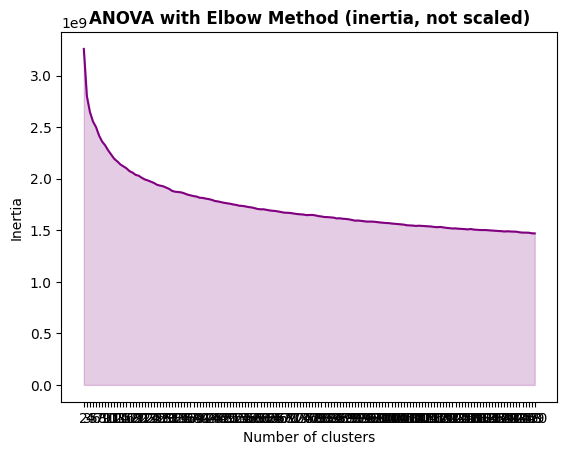

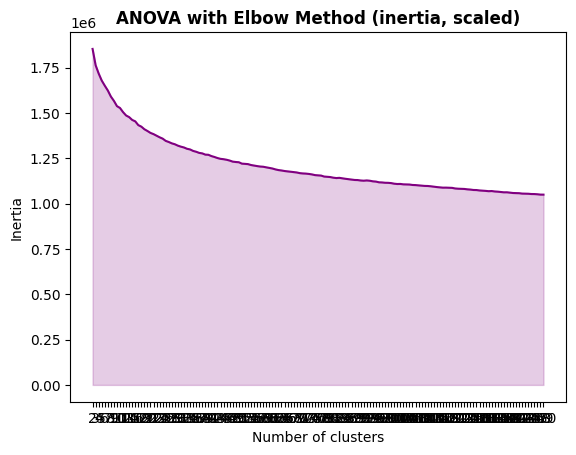

In [6]:
from img_ml import select_k_with_anova

select_k_with_anova(data, k_min=2, k_max=150)
select_k_with_anova(data, k_min=2, k_max=150, normalize=True)

#### Silhouette

In [ ]:
from img_ml import select_k_with_anova
select_k_with_anova(descs, k_min=2, k_max=150, metric='silhouette', color='green')
select_k_with_anova(descs, k_min=2, k_max=150, metric='silhouette', color='green', normalize=True)

#### Davis-Bouldin

In [4]:
from img_ml import select_k_with_davies_bouldin
select_k_with_davies_bouldin(descs, normalize=True, k_min=2, k_max=1_000)

MemoryError: Unable to allocate 15.2 MiB for an array with shape (15547, 128) and data type float64

### Clusters de descripteurs

In [6]:
import time
from sklearn import cluster, metrics

# Determination number of clusters
t = time.time()

print(f"Création de {k} clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, n_init='auto', random_state=42)
kmeans.fit(descs)

dt = time.time() - t
print(f"temps de traitement kmeans : {dt:15.2f} secondes")

Nombre de clusters estimés :  125
Création de 125 clusters de descripteurs ...


'# Clustering\nkmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)\nkmeans.fit(sift_keypoints_all)\n\ndt = time.time() - t\nprint("temps de traitement kmeans : {dt:15.2f} secondes")'

### Création des features des images

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

Je ne suis pas bien certain d'avoir compris, par manque de commentaires et cf. la logique..

D'abord, on fait de la prédiction partant de la base d'apprentissage... hum.. discutable. On aurait pu conserver l'association image / descripteurs, et disposer directement du mappage et s'éviter de refaire des prédictions inutiles.

In [ ]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0 :
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i % 100 == 0 :
        print(i)  
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
temps de création histogrammes :             0.95 secondes


## Réduction dimensionnelle

